<a href="https://colab.research.google.com/github/rishubhkhurana/MLFinance/blob/master/Notebooks/ISBData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ISB Datasets--EDA

### Importing Libs

In [0]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
datapath= '/content/gdrive/My Drive/Prowess Data/'

In [6]:
!ls '/content/gdrive/My Drive/Prowess Data/'

'Annual Statements.zip'  'Quarterly Statements.zip'
 F-Score.zip		  StockReturns2011To2014.txt
 G-Score.zip		 'Trading Data.zip'


In [0]:
import pandas as pd
import numpy as np
import zipfile
from glob import glob
import re
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl

In [0]:
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [0]:
Path.ls = lambda x: list(x.iterdir())

### Unzipping files

In [27]:
_zipfiles = glob(datapath+'/*.zip')
_zipfiles

['/content/gdrive/My Drive/Prowess Data/Annual Statements.zip',
 '/content/gdrive/My Drive/Prowess Data/Quarterly Statements.zip',
 '/content/gdrive/My Drive/Prowess Data/Trading Data.zip',
 '/content/gdrive/My Drive/Prowess Data/F-Score.zip',
 '/content/gdrive/My Drive/Prowess Data/G-Score.zip']

In [0]:
for f in _zipfiles:
  temp_file = zipfile.ZipFile(f)
  temp_list = temp_file.namelist()
  pathname = './'+f.split('.')[0]
  os.makedirs(pathname,exist_ok=True)
  temp_file.extractall(path=pathname)

  if any([True if re.search(r'\.zip',name) else False for name in temp_list]):
    for sf in temp_list:
      temp_sf = zipfile.ZipFile(pathname+'/'+sf)
      temp_sf.extractall(path=pathname)
      temp_sf.close()
    #print(temp_list)
  temp_file.close()
 


In [41]:
!ls './content/gdrive/My Drive/'

'Prowess Data'


### EDA -- Trading data

In [0]:
tradingpath = Path('./content/gdrive/My Drive/Prowess Data/Trading Data')

In [0]:
list_of_trading_dfs = []
for f in tradingpath.ls():
  list_of_trading_dfs.append(pd.read_csv(f,delimiter='|'))

In [53]:
list_of_trading_dfs[0].head()

,co_code,Prowess company code,Code
0,company_name,Prowess company name,Text
1,co_stkdate,Company Trading Date,Date
2,bse_closing_price,BSE closing price,Indian Rupee
3,bse_market_cap,BSE market capitalisation,Rs. Million
4,bse_pb,BSE P/B,Times


In [54]:
list_of_trading_dfs[1].head()

,co_code,company_name,co_stkdate,bse_closing_price,bse_market_cap,bse_pb,nse_closing_price,nse_market_cap,nse_pb
0,11,20 MICRONS LTD.,20081006,33.30,470.2100,1.1619,33.65,475.1521,1.1741
1,11,20 MICRONS LTD.,20081007,30.40,429.2607,1.0607,30.10,425.0246,1.0502
2,11,20 MICRONS LTD.,20081008,26.35,372.0730,0.9194,26.50,374.1911,0.9246
3,11,20 MICRONS LTD.,20081010,23.35,329.7118,0.8147,23.20,327.5937,0.8095
4,11,20 MICRONS LTD.,20081013,24.90,351.5984,0.8688,24.65,348.0683,0.8601


In [0]:
trading_df = list_of_trading_dfs[1]

In [0]:
trading_df.loc[:,'co_stkdate'] = pd.to_datetime(trading_df['co_stkdate'],format='%Y%m%d')

In [59]:
print(f"Number of Unique Company names in data: {trading_df.company_name.nunique()}")


Number of Unique Company names in data: 6672


So, we have data belonging to 6672 companies but do we have trading data for all these companies. Let's see how many companies have non null data

In [64]:
print(f"Companies with not all Null entries-> {sum(trading_df.groupby('company_name')['nse_closing_price'].agg(lambda x: not all(np.isnan(x))))}")

Companies with not all Null entries-> 2710


So only 2710 companies with not null data. Let's plot the histogram of number of null entries for each of these companies

In [0]:
num_entries_per_comp = trading_df.groupby('company_name')['nse_closing_price'].agg(lambda x: sum(~np.isnan(x))).reset_index().query('nse_closing_price!=0')

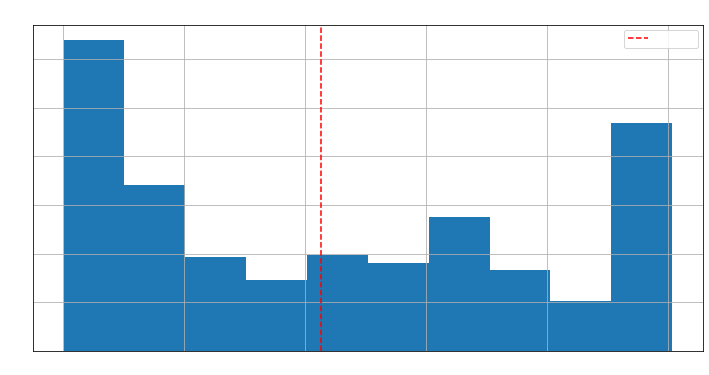

In [85]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
num_entries_per_comp['nse_closing_price'].hist(ax=ax)
ax.set_title('Histogram of Number of Trading days',fontsize=16)#,fontcolor='white')
ax.axvline(num_entries_per_comp['nse_closing_price'].median(),linestyle='--',c='r',label='median')
plt.legend()
plt.show()

let's see the time span for which we have available data

In [90]:
print(f"latest date--> {trading_df.co_stkdate.max().date()}")
print(f"earliest date--> {trading_df.co_stkdate.min().date()}")

latest date--> 2020-03-31
earliest date--> 2000-01-03


we have almost last twenty years of data. Lot of regime change must have happened during this time. It will be interesting to see how the correlation between different stocks moved during this time

But first let's plot some time series for the stock who has maximum available data

In [0]:
max_data_company = num_entries_per_comp.loc[num_entries_per_comp['nse_closing_price'].argmax(),'company_name']

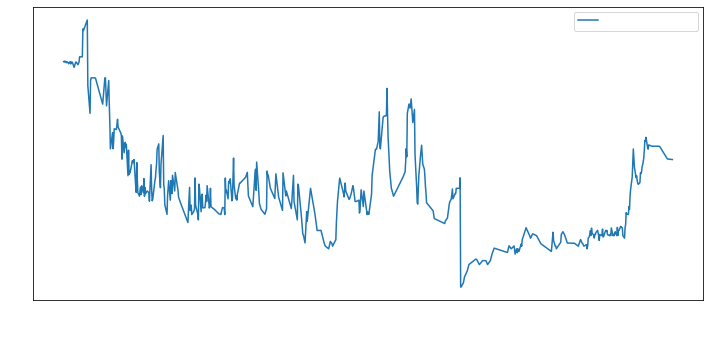

In [98]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
trading_df.query('company_name==@max_data_company')[['co_stkdate','nse_closing_price']].set_index('co_stkdate').plot(ax=ax)
plt.show()

Let's estimate the volatility of every stock and annualize returns for every stock

In [99]:
trading_df_filt  = trading_df.query('company_name.isin(@num_entries_per_comp["company_name"])')

UndefinedVariableError: ignored